<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[22:10:11] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


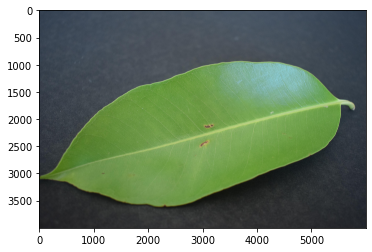

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

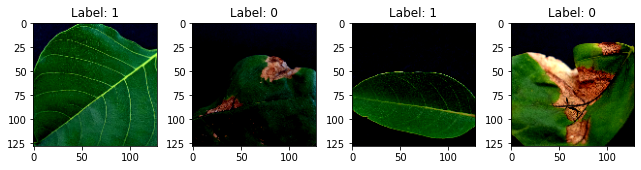

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
device = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, device=device)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), device=device))
model.hybridize()

[22:10:18] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[22:10:20] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.to_device(device))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.to_device(device))
            loss = loss_fn(outputs, label.to_device(device))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2472230001106928 samples/sec                   batch loss = 1.0327250957489014 | accuracy = 0.3


Epoch[1] Batch[10] Speed: 1.261365715864133 samples/sec                   batch loss = 1.2537940740585327 | accuracy = 0.4


Epoch[1] Batch[15] Speed: 1.265132626073703 samples/sec                   batch loss = 0.8905618786811829 | accuracy = 0.43333333333333335


Epoch[1] Batch[20] Speed: 1.2574931634011766 samples/sec                   batch loss = 0.39658987522125244 | accuracy = 0.525


Epoch[1] Batch[25] Speed: 1.2594631934746878 samples/sec                   batch loss = 0.7672796249389648 | accuracy = 0.52


Epoch[1] Batch[30] Speed: 1.2625690680806978 samples/sec                   batch loss = 0.6063388586044312 | accuracy = 0.5416666666666666


Epoch[1] Batch[35] Speed: 1.261395304635412 samples/sec                   batch loss = 0.25170576572418213 | accuracy = 0.5642857142857143


Epoch[1] Batch[40] Speed: 1.2668879532566122 samples/sec                   batch loss = 0.6049909591674805 | accuracy = 0.5625


Epoch[1] Batch[45] Speed: 1.270075788716979 samples/sec                   batch loss = 0.681180477142334 | accuracy = 0.5666666666666667


Epoch[1] Batch[50] Speed: 1.2682108599994724 samples/sec                   batch loss = 0.7524104118347168 | accuracy = 0.575


Epoch[1] Batch[55] Speed: 1.2669833391985719 samples/sec                   batch loss = 0.47303298115730286 | accuracy = 0.5818181818181818


Epoch[1] Batch[60] Speed: 1.2620396787026908 samples/sec                   batch loss = 1.3126769065856934 | accuracy = 0.5958333333333333


Epoch[1] Batch[65] Speed: 1.2668345740128206 samples/sec                   batch loss = 0.2722878158092499 | accuracy = 0.6038461538461538


Epoch[1] Batch[70] Speed: 1.2675887096676703 samples/sec                   batch loss = 0.8520544171333313 | accuracy = 0.5964285714285714


Epoch[1] Batch[75] Speed: 1.2633736891828984 samples/sec                   batch loss = 0.3625006377696991 | accuracy = 0.6


Epoch[1] Batch[80] Speed: 1.2714719457120223 samples/sec                   batch loss = 0.2889171242713928 | accuracy = 0.615625


Epoch[1] Batch[85] Speed: 1.2675622772520492 samples/sec                   batch loss = 0.9381410479545593 | accuracy = 0.611764705882353


Epoch[1] Batch[90] Speed: 1.2633978541263788 samples/sec                   batch loss = 0.7947720289230347 | accuracy = 0.6166666666666667


Epoch[1] Batch[95] Speed: 1.264684114966952 samples/sec                   batch loss = 0.31159114837646484 | accuracy = 0.618421052631579


Epoch[1] Batch[100] Speed: 1.27432014031089 samples/sec                   batch loss = 0.30610448122024536 | accuracy = 0.6275


Epoch[1] Batch[105] Speed: 1.2690034929860416 samples/sec                   batch loss = 0.6906865239143372 | accuracy = 0.6190476190476191


Epoch[1] Batch[110] Speed: 1.2664095182165271 samples/sec                   batch loss = 0.16358064115047455 | accuracy = 0.6272727272727273


Epoch[1] Batch[115] Speed: 1.277729522833533 samples/sec                   batch loss = 0.27540889382362366 | accuracy = 0.6326086956521739


Epoch[1] Batch[120] Speed: 1.2695006047018815 samples/sec                   batch loss = 0.8037225604057312 | accuracy = 0.6291666666666667


Epoch[1] Batch[125] Speed: 1.2709322736736401 samples/sec                   batch loss = 0.4181450307369232 | accuracy = 0.63


Epoch[1] Batch[130] Speed: 1.2701834833907686 samples/sec                   batch loss = 0.544950008392334 | accuracy = 0.6326923076923077


Epoch[1] Batch[135] Speed: 1.266937988424095 samples/sec                   batch loss = 0.37406519055366516 | accuracy = 0.6314814814814815


Epoch[1] Batch[140] Speed: 1.2679258196237202 samples/sec                   batch loss = 0.5021831393241882 | accuracy = 0.6357142857142857


Epoch[1] Batch[145] Speed: 1.2696769967262174 samples/sec                   batch loss = 0.6247791647911072 | accuracy = 0.6293103448275862


Epoch[1] Batch[150] Speed: 1.2657241969899282 samples/sec                   batch loss = 0.4182327091693878 | accuracy = 0.635


Epoch[1] Batch[155] Speed: 1.2663613409172634 samples/sec                   batch loss = 0.5987851023674011 | accuracy = 0.6403225806451613


Epoch[1] Batch[160] Speed: 1.269518280124149 samples/sec                   batch loss = 0.2945038378238678 | accuracy = 0.6421875


Epoch[1] Batch[165] Speed: 1.2695087699173049 samples/sec                   batch loss = 0.42683184146881104 | accuracy = 0.6454545454545455


Epoch[1] Batch[170] Speed: 1.265917784991571 samples/sec                   batch loss = 0.6456677317619324 | accuracy = 0.6470588235294118


Epoch[1] Batch[175] Speed: 1.2658956249031368 samples/sec                   batch loss = 0.7039873600006104 | accuracy = 0.6471428571428571


Epoch[1] Batch[180] Speed: 1.2702651319701181 samples/sec                   batch loss = 0.5740338563919067 | accuracy = 0.65


Epoch[1] Batch[185] Speed: 1.2704650181351491 samples/sec                   batch loss = 0.32222309708595276 | accuracy = 0.6486486486486487


Epoch[1] Batch[190] Speed: 1.2719474639466632 samples/sec                   batch loss = 0.7416093945503235 | accuracy = 0.65


Epoch[1] Batch[195] Speed: 1.2685531927667162 samples/sec                   batch loss = 0.6440054178237915 | accuracy = 0.65


Epoch[1] Batch[200] Speed: 1.2722862212046289 samples/sec                   batch loss = 0.47009122371673584 | accuracy = 0.65125


Epoch[1] Batch[205] Speed: 1.2719201744472504 samples/sec                   batch loss = 0.8495718240737915 | accuracy = 0.651219512195122


Epoch[1] Batch[210] Speed: 1.2729410006232984 samples/sec                   batch loss = 0.27889764308929443 | accuracy = 0.6535714285714286


Epoch[1] Batch[215] Speed: 1.2748858472471307 samples/sec                   batch loss = 0.4019201397895813 | accuracy = 0.6581395348837209


Epoch[1] Batch[220] Speed: 1.27227647651976 samples/sec                   batch loss = 0.5452062487602234 | accuracy = 0.6579545454545455


Epoch[1] Batch[225] Speed: 1.2636483106481617 samples/sec                   batch loss = 0.7992730736732483 | accuracy = 0.6544444444444445


Epoch[1] Batch[230] Speed: 1.2668295041751905 samples/sec                   batch loss = 0.39070165157318115 | accuracy = 0.6565217391304348


Epoch[1] Batch[235] Speed: 1.2643042309222663 samples/sec                   batch loss = 0.5039212703704834 | accuracy = 0.6585106382978724


Epoch[1] Batch[240] Speed: 1.2726760344996435 samples/sec                   batch loss = 0.6054279208183289 | accuracy = 0.6614583333333334


Epoch[1] Batch[245] Speed: 1.2773333016611743 samples/sec                   batch loss = 0.4584043622016907 | accuracy = 0.6632653061224489


Epoch[1] Batch[250] Speed: 1.271053787527878 samples/sec                   batch loss = 0.4496050775051117 | accuracy = 0.662


Epoch[1] Batch[255] Speed: 1.2733120806214673 samples/sec                   batch loss = 1.108461856842041 | accuracy = 0.6588235294117647


Epoch[1] Batch[260] Speed: 1.2720630957008734 samples/sec                   batch loss = 0.4105914831161499 | accuracy = 0.6625


Epoch[1] Batch[265] Speed: 1.2738105433741445 samples/sec                   batch loss = 0.3896547853946686 | accuracy = 0.6660377358490566


Epoch[1] Batch[270] Speed: 1.2703446748960499 samples/sec                   batch loss = 0.5956111550331116 | accuracy = 0.662962962962963


Epoch[1] Batch[275] Speed: 1.2674691022026874 samples/sec                   batch loss = 0.6429573893547058 | accuracy = 0.6627272727272727


Epoch[1] Batch[280] Speed: 1.271025766028056 samples/sec                   batch loss = 1.0217554569244385 | accuracy = 0.6633928571428571


Epoch[1] Batch[285] Speed: 1.2712138515291043 samples/sec                   batch loss = 0.7277407646179199 | accuracy = 0.6614035087719298


Epoch[1] Batch[290] Speed: 1.269313890088683 samples/sec                   batch loss = 0.6448308825492859 | accuracy = 0.6629310344827586


Epoch[1] Batch[295] Speed: 1.262681670436274 samples/sec                   batch loss = 0.4910275638103485 | accuracy = 0.661864406779661


Epoch[1] Batch[300] Speed: 1.264693934364157 samples/sec                   batch loss = 0.32748836278915405 | accuracy = 0.665


Epoch[1] Batch[305] Speed: 1.2607415457497806 samples/sec                   batch loss = 0.5415424704551697 | accuracy = 0.6663934426229509


Epoch[1] Batch[310] Speed: 1.2684632286112991 samples/sec                   batch loss = 0.7277827858924866 | accuracy = 0.6653225806451613


Epoch[1] Batch[315] Speed: 1.2727614798163278 samples/sec                   batch loss = 0.4147774577140808 | accuracy = 0.6682539682539682


Epoch[1] Batch[320] Speed: 1.2704156659915233 samples/sec                   batch loss = 0.07119578868150711 | accuracy = 0.671875


Epoch[1] Batch[325] Speed: 1.266387149728859 samples/sec                   batch loss = 0.3340633511543274 | accuracy = 0.6746153846153846


Epoch[1] Batch[330] Speed: 1.2707072166788078 samples/sec                   batch loss = 0.22042450308799744 | accuracy = 0.675


Epoch[1] Batch[335] Speed: 1.2737043601473612 samples/sec                   batch loss = 0.456718385219574 | accuracy = 0.6753731343283582


Epoch[1] Batch[340] Speed: 1.265599881113445 samples/sec                   batch loss = 0.6296929121017456 | accuracy = 0.6779411764705883


Epoch[1] Batch[345] Speed: 1.2722252470179642 samples/sec                   batch loss = 0.46656861901283264 | accuracy = 0.6753623188405797


Epoch[1] Batch[350] Speed: 1.2684596801801966 samples/sec                   batch loss = 0.3395872116088867 | accuracy = 0.6778571428571428


Epoch[1] Batch[355] Speed: 1.2729235195028614 samples/sec                   batch loss = 0.7187905311584473 | accuracy = 0.6788732394366197


Epoch[1] Batch[360] Speed: 1.273373062385217 samples/sec                   batch loss = 0.5346578359603882 | accuracy = 0.6798611111111111


Epoch[1] Batch[365] Speed: 1.2685860932936008 samples/sec                   batch loss = 0.39452454447746277 | accuracy = 0.678082191780822


Epoch[1] Batch[370] Speed: 1.2677979094034528 samples/sec                   batch loss = 1.9952939748764038 | accuracy = 0.677027027027027


Epoch[1] Batch[375] Speed: 1.2715667703415663 samples/sec                   batch loss = 0.5570942163467407 | accuracy = 0.678


Epoch[1] Batch[380] Speed: 1.270477140300838 samples/sec                   batch loss = 0.6537330746650696 | accuracy = 0.6763157894736842


Epoch[1] Batch[385] Speed: 1.2726053697535855 samples/sec                   batch loss = 0.4772345721721649 | accuracy = 0.675974025974026


Epoch[1] Batch[390] Speed: 1.268617460691097 samples/sec                   batch loss = 0.5571487545967102 | accuracy = 0.6775641025641026


Epoch[1] Batch[395] Speed: 1.2720285679214098 samples/sec                   batch loss = 0.8735838532447815 | accuracy = 0.6753164556962026


Epoch[1] Batch[400] Speed: 1.2669026859546726 samples/sec                   batch loss = 0.3421332538127899 | accuracy = 0.675625


Epoch[1] Batch[405] Speed: 1.2725094249965205 samples/sec                   batch loss = 0.8390305638313293 | accuracy = 0.6753086419753086


Epoch[1] Batch[410] Speed: 1.2699643631862076 samples/sec                   batch loss = 0.39331769943237305 | accuracy = 0.675


Epoch[1] Batch[415] Speed: 1.270693550258589 samples/sec                   batch loss = 0.5995833277702332 | accuracy = 0.6740963855421687


Epoch[1] Batch[420] Speed: 1.2717715009962474 samples/sec                   batch loss = 0.33857461810112 | accuracy = 0.675


Epoch[1] Batch[425] Speed: 1.2661400974244414 samples/sec                   batch loss = 1.0300259590148926 | accuracy = 0.6747058823529412


Epoch[1] Batch[430] Speed: 1.2706331135586175 samples/sec                   batch loss = 0.22520752251148224 | accuracy = 0.6761627906976744


Epoch[1] Batch[435] Speed: 1.268727498658465 samples/sec                   batch loss = 0.5881767272949219 | accuracy = 0.6770114942528735


Epoch[1] Batch[440] Speed: 1.266755278745997 samples/sec                   batch loss = 0.5436689257621765 | accuracy = 0.6772727272727272


Epoch[1] Batch[445] Speed: 1.2701230951994855 samples/sec                   batch loss = 0.4788772463798523 | accuracy = 0.6758426966292135


Epoch[1] Batch[450] Speed: 1.266647112671404 samples/sec                   batch loss = 0.40854018926620483 | accuracy = 0.6761111111111111


Epoch[1] Batch[455] Speed: 1.2603890229996062 samples/sec                   batch loss = 0.5400009751319885 | accuracy = 0.6758241758241759


Epoch[1] Batch[460] Speed: 1.2608690783524186 samples/sec                   batch loss = 0.3618467450141907 | accuracy = 0.6760869565217391


Epoch[1] Batch[465] Speed: 1.2621536109263165 samples/sec                   batch loss = 0.9421753287315369 | accuracy = 0.6763440860215054


Epoch[1] Batch[470] Speed: 1.2710456987206673 samples/sec                   batch loss = 1.1992547512054443 | accuracy = 0.675531914893617


Epoch[1] Batch[475] Speed: 1.2662895597177624 samples/sec                   batch loss = 1.2640730142593384 | accuracy = 0.6763157894736842


Epoch[1] Batch[480] Speed: 1.2677792280482323 samples/sec                   batch loss = 0.8673000335693359 | accuracy = 0.6734375


Epoch[1] Batch[485] Speed: 1.2714873633881076 samples/sec                   batch loss = 0.8706194162368774 | accuracy = 0.6721649484536083


Epoch[1] Batch[490] Speed: 1.264916103221917 samples/sec                   batch loss = 0.7676241397857666 | accuracy = 0.6744897959183673


Epoch[1] Batch[495] Speed: 1.264107326205187 samples/sec                   batch loss = 0.586775541305542 | accuracy = 0.6752525252525252


Epoch[1] Batch[500] Speed: 1.269333384982641 samples/sec                   batch loss = 0.36111313104629517 | accuracy = 0.675


Epoch[1] Batch[505] Speed: 1.265335385357052 samples/sec                   batch loss = 0.831509530544281 | accuracy = 0.6752475247524753


Epoch[1] Batch[510] Speed: 1.2715453757445137 samples/sec                   batch loss = 0.3139476180076599 | accuracy = 0.6769607843137255


Epoch[1] Batch[515] Speed: 1.2646688618367998 samples/sec                   batch loss = 0.31689730286598206 | accuracy = 0.6786407766990291


Epoch[1] Batch[520] Speed: 1.2614869248266634 samples/sec                   batch loss = 0.3379323184490204 | accuracy = 0.6788461538461539


Epoch[1] Batch[525] Speed: 1.2659107166032348 samples/sec                   batch loss = 0.6985833048820496 | accuracy = 0.6776190476190476


Epoch[1] Batch[530] Speed: 1.2714203955728434 samples/sec                   batch loss = 0.4045140743255615 | accuracy = 0.6792452830188679


Epoch[1] Batch[535] Speed: 1.2666597358764955 samples/sec                   batch loss = 0.36966997385025024 | accuracy = 0.6789719626168225


Epoch[1] Batch[540] Speed: 1.2636995180122128 samples/sec                   batch loss = 0.7628023028373718 | accuracy = 0.6787037037037037


Epoch[1] Batch[545] Speed: 1.2631851582586415 samples/sec                   batch loss = 0.7712104320526123 | accuracy = 0.6784403669724771


Epoch[1] Batch[550] Speed: 1.268843121445487 samples/sec                   batch loss = 0.676239550113678 | accuracy = 0.6795454545454546


Epoch[1] Batch[555] Speed: 1.2664025399283043 samples/sec                   batch loss = 0.43293485045433044 | accuracy = 0.6806306306306307


Epoch[1] Batch[560] Speed: 1.262929751537936 samples/sec                   batch loss = 0.33882540464401245 | accuracy = 0.6816964285714285


Epoch[1] Batch[565] Speed: 1.2682393327379633 samples/sec                   batch loss = 0.3801954388618469 | accuracy = 0.6836283185840708


Epoch[1] Batch[570] Speed: 1.2651808053344893 samples/sec                   batch loss = 0.421694278717041 | accuracy = 0.6837719298245614


Epoch[1] Batch[575] Speed: 1.2671296510638594 samples/sec                   batch loss = 0.48765626549720764 | accuracy = 0.6834782608695652


Epoch[1] Batch[580] Speed: 1.2710716988245105 samples/sec                   batch loss = 0.44413021206855774 | accuracy = 0.684051724137931


Epoch[1] Batch[585] Speed: 1.267554137056219 samples/sec                   batch loss = 1.0339607000350952 | accuracy = 0.6837606837606838


Epoch[1] Batch[590] Speed: 1.2644795629812302 samples/sec                   batch loss = 0.5930367708206177 | accuracy = 0.6838983050847458


Epoch[1] Batch[595] Speed: 1.2613063528364556 samples/sec                   batch loss = 0.9467107653617859 | accuracy = 0.6827731092436975


Epoch[1] Batch[600] Speed: 1.2649385151440076 samples/sec                   batch loss = 0.8576130270957947 | accuracy = 0.6820833333333334


Epoch[1] Batch[605] Speed: 1.2762336734981854 samples/sec                   batch loss = 0.8222489953041077 | accuracy = 0.6822314049586777


Epoch[1] Batch[610] Speed: 1.2651991239568483 samples/sec                   batch loss = 0.857337236404419 | accuracy = 0.6823770491803278


Epoch[1] Batch[615] Speed: 1.2678379564199445 samples/sec                   batch loss = 0.26834774017333984 | accuracy = 0.6813008130081301


Epoch[1] Batch[620] Speed: 1.2688645211684446 samples/sec                   batch loss = 0.3498400151729584 | accuracy = 0.6818548387096774


Epoch[1] Batch[625] Speed: 1.2696777654261744 samples/sec                   batch loss = 1.0331571102142334 | accuracy = 0.6804


Epoch[1] Batch[630] Speed: 1.2658594253930833 samples/sec                   batch loss = 0.7646545767784119 | accuracy = 0.6801587301587302


Epoch[1] Batch[635] Speed: 1.2688802595419293 samples/sec                   batch loss = 0.35421261191368103 | accuracy = 0.681496062992126


Epoch[1] Batch[640] Speed: 1.2727039357200618 samples/sec                   batch loss = 0.6253206729888916 | accuracy = 0.681640625


Epoch[1] Batch[645] Speed: 1.2588518611476587 samples/sec                   batch loss = 0.3901982009410858 | accuracy = 0.6821705426356589


Epoch[1] Batch[650] Speed: 1.2661693372707319 samples/sec                   batch loss = 0.6270263195037842 | accuracy = 0.6826923076923077


Epoch[1] Batch[655] Speed: 1.2654411322131742 samples/sec                   batch loss = 0.40935951471328735 | accuracy = 0.683969465648855


Epoch[1] Batch[660] Speed: 1.266937318711246 samples/sec                   batch loss = 0.41986560821533203 | accuracy = 0.684469696969697


Epoch[1] Batch[665] Speed: 1.2601997725555354 samples/sec                   batch loss = 0.6036441326141357 | accuracy = 0.6853383458646617


Epoch[1] Batch[670] Speed: 1.264642741705944 samples/sec                   batch loss = 0.2926151752471924 | accuracy = 0.6861940298507463


Epoch[1] Batch[675] Speed: 1.2613402061468135 samples/sec                   batch loss = 0.5405223369598389 | accuracy = 0.687037037037037


Epoch[1] Batch[680] Speed: 1.2631011840414186 samples/sec                   batch loss = 0.25909432768821716 | accuracy = 0.6882352941176471


Epoch[1] Batch[685] Speed: 1.2656140110274545 samples/sec                   batch loss = 0.3958705961704254 | accuracy = 0.6883211678832116


Epoch[1] Batch[690] Speed: 1.2663278866160141 samples/sec                   batch loss = 0.28886303305625916 | accuracy = 0.688768115942029


Epoch[1] Batch[695] Speed: 1.2694521919351893 samples/sec                   batch loss = 1.6397184133529663 | accuracy = 0.6888489208633094


Epoch[1] Batch[700] Speed: 1.2624571507904647 samples/sec                   batch loss = 0.5260997414588928 | accuracy = 0.6889285714285714


Epoch[1] Batch[705] Speed: 1.2660125472248973 samples/sec                   batch loss = 0.4309970438480377 | accuracy = 0.6882978723404255


Epoch[1] Batch[710] Speed: 1.2656841879100011 samples/sec                   batch loss = 0.9680280685424805 | accuracy = 0.6894366197183098


Epoch[1] Batch[715] Speed: 1.2638223183763742 samples/sec                   batch loss = 0.41297993063926697 | accuracy = 0.6902097902097902


Epoch[1] Batch[720] Speed: 1.2626105908312337 samples/sec                   batch loss = 0.42488768696784973 | accuracy = 0.6913194444444445


Epoch[1] Batch[725] Speed: 1.2659397548106148 samples/sec                   batch loss = 0.6980717778205872 | accuracy = 0.6910344827586207


Epoch[1] Batch[730] Speed: 1.2687764318718102 samples/sec                   batch loss = 0.5847291350364685 | accuracy = 0.6914383561643835


Epoch[1] Batch[735] Speed: 1.2712624950870584 samples/sec                   batch loss = 0.3816930949687958 | accuracy = 0.6918367346938775


Epoch[1] Batch[740] Speed: 1.2723540522062662 samples/sec                   batch loss = 0.4575115740299225 | accuracy = 0.6925675675675675


Epoch[1] Batch[745] Speed: 1.26627981110129 samples/sec                   batch loss = 0.33178845047950745 | accuracy = 0.6926174496644295


Epoch[1] Batch[750] Speed: 1.2701796368379301 samples/sec                   batch loss = 0.36209022998809814 | accuracy = 0.6933333333333334


Epoch[1] Batch[755] Speed: 1.2689684592370782 samples/sec                   batch loss = 0.5890321731567383 | accuracy = 0.6930463576158941


Epoch[1] Batch[760] Speed: 1.2732097487588887 samples/sec                   batch loss = 0.2919735014438629 | accuracy = 0.6944078947368421


Epoch[1] Batch[765] Speed: 1.2678250222983043 samples/sec                   batch loss = 0.8929104804992676 | accuracy = 0.6944444444444444


Epoch[1] Batch[770] Speed: 1.2687041847491425 samples/sec                   batch loss = 0.23492294549942017 | accuracy = 0.6948051948051948


Epoch[1] Batch[775] Speed: 1.2675451350790432 samples/sec                   batch loss = 0.3626740276813507 | accuracy = 0.6951612903225807


Epoch[1] Batch[780] Speed: 1.2679124046064447 samples/sec                   batch loss = 0.46555566787719727 | accuracy = 0.6955128205128205


Epoch[1] Batch[785] Speed: 1.2676604466698256 samples/sec                   batch loss = 0.3968082368373871 | accuracy = 0.6968152866242038


[Epoch 1] training: accuracy=0.6970177664974619
[Epoch 1] time cost: 648.4091055393219
[Epoch 1] validation: validation accuracy=0.7311111111111112


Epoch[2] Batch[5] Speed: 1.2648348547418784 samples/sec                   batch loss = 0.25886812806129456 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.2679151834081412 samples/sec                   batch loss = 0.47227585315704346 | accuracy = 0.7


Epoch[2] Batch[15] Speed: 1.2621041428258912 samples/sec                   batch loss = 0.37901243567466736 | accuracy = 0.6833333333333333


Epoch[2] Batch[20] Speed: 1.2683052947000988 samples/sec                   batch loss = 0.5919205546379089 | accuracy = 0.7


Epoch[2] Batch[25] Speed: 1.266944972614571 samples/sec                   batch loss = 0.7234213352203369 | accuracy = 0.69


Epoch[2] Batch[30] Speed: 1.2611385355285896 samples/sec                   batch loss = 1.2272071838378906 | accuracy = 0.675


Epoch[2] Batch[35] Speed: 1.2671640091081764 samples/sec                   batch loss = 0.34426426887512207 | accuracy = 0.7


Epoch[2] Batch[40] Speed: 1.2657596248022016 samples/sec                   batch loss = 0.5023583173751831 | accuracy = 0.6875


Epoch[2] Batch[45] Speed: 1.2667645564489733 samples/sec                   batch loss = 0.19986405968666077 | accuracy = 0.6944444444444444


Epoch[2] Batch[50] Speed: 1.265632915054471 samples/sec                   batch loss = 1.143635869026184 | accuracy = 0.695


Epoch[2] Batch[55] Speed: 1.2653041800505347 samples/sec                   batch loss = 0.611416757106781 | accuracy = 0.7181818181818181


Epoch[2] Batch[60] Speed: 1.2653357670828689 samples/sec                   batch loss = 0.20138178765773773 | accuracy = 0.725


Epoch[2] Batch[65] Speed: 1.26642538693904 samples/sec                   batch loss = 0.9024586081504822 | accuracy = 0.7153846153846154


Epoch[2] Batch[70] Speed: 1.26785002850491 samples/sec                   batch loss = 0.2662825584411621 | accuracy = 0.7214285714285714


Epoch[2] Batch[75] Speed: 1.2745478345842511 samples/sec                   batch loss = 0.1562374383211136 | accuracy = 0.7233333333333334


Epoch[2] Batch[80] Speed: 1.2710955813386144 samples/sec                   batch loss = 0.4585319757461548 | accuracy = 0.728125


Epoch[2] Batch[85] Speed: 1.2769058375315978 samples/sec                   batch loss = 0.7762686610221863 | accuracy = 0.7294117647058823


Epoch[2] Batch[90] Speed: 1.2757708554330014 samples/sec                   batch loss = 0.2514621615409851 | accuracy = 0.7305555555555555


Epoch[2] Batch[95] Speed: 1.269606664618916 samples/sec                   batch loss = 0.4546031355857849 | accuracy = 0.7315789473684211


Epoch[2] Batch[100] Speed: 1.2702265663742944 samples/sec                   batch loss = 0.5890528559684753 | accuracy = 0.73


Epoch[2] Batch[105] Speed: 1.2679701870241393 samples/sec                   batch loss = 0.7739551067352295 | accuracy = 0.7261904761904762


Epoch[2] Batch[110] Speed: 1.2713581555548854 samples/sec                   batch loss = 0.7161091566085815 | accuracy = 0.7181818181818181


Epoch[2] Batch[115] Speed: 1.2679796741930498 samples/sec                   batch loss = 0.2559715211391449 | accuracy = 0.7282608695652174


Epoch[2] Batch[120] Speed: 1.2663311363849077 samples/sec                   batch loss = 0.5582184791564941 | accuracy = 0.7291666666666666


Epoch[2] Batch[125] Speed: 1.2700122381972403 samples/sec                   batch loss = 0.47877150774002075 | accuracy = 0.726


Epoch[2] Batch[130] Speed: 1.2721120936441999 samples/sec                   batch loss = 0.4485134780406952 | accuracy = 0.7269230769230769


Epoch[2] Batch[135] Speed: 1.2725319137671816 samples/sec                   batch loss = 0.3069700598716736 | accuracy = 0.7314814814814815


Epoch[2] Batch[140] Speed: 1.26567549892147 samples/sec                   batch loss = 0.5603735446929932 | accuracy = 0.7303571428571428


Epoch[2] Batch[145] Speed: 1.2654497225354107 samples/sec                   batch loss = 1.1591897010803223 | accuracy = 0.7275862068965517


Epoch[2] Batch[150] Speed: 1.2665356186192305 samples/sec                   batch loss = 0.5200609564781189 | accuracy = 0.7283333333333334


Epoch[2] Batch[155] Speed: 1.2698576668117127 samples/sec                   batch loss = 0.4772433638572693 | accuracy = 0.7274193548387097


Epoch[2] Batch[160] Speed: 1.2667159695741415 samples/sec                   batch loss = 0.5230200290679932 | accuracy = 0.73125


Epoch[2] Batch[165] Speed: 1.2718498828612304 samples/sec                   batch loss = 0.31335264444351196 | accuracy = 0.7363636363636363


Epoch[2] Batch[170] Speed: 1.2666872782882237 samples/sec                   batch loss = 0.42603859305381775 | accuracy = 0.7338235294117647


Epoch[2] Batch[175] Speed: 1.268183443015137 samples/sec                   batch loss = 0.47463271021842957 | accuracy = 0.7328571428571429


Epoch[2] Batch[180] Speed: 1.2710126704930143 samples/sec                   batch loss = 0.8087843060493469 | accuracy = 0.7333333333333333


Epoch[2] Batch[185] Speed: 1.2749576374807945 samples/sec                   batch loss = 0.36634618043899536 | accuracy = 0.7324324324324324


Epoch[2] Batch[190] Speed: 1.2689679793361395 samples/sec                   batch loss = 0.9002166986465454 | accuracy = 0.7276315789473684


Epoch[2] Batch[195] Speed: 1.2684393490117687 samples/sec                   batch loss = 0.21223081648349762 | accuracy = 0.7294871794871794


Epoch[2] Batch[200] Speed: 1.2711316957157344 samples/sec                   batch loss = 0.39361947774887085 | accuracy = 0.73


Epoch[2] Batch[205] Speed: 1.2705690261418654 samples/sec                   batch loss = 0.43560099601745605 | accuracy = 0.7292682926829268


Epoch[2] Batch[210] Speed: 1.27038565252776 samples/sec                   batch loss = 0.2494327276945114 | accuracy = 0.7285714285714285


Epoch[2] Batch[215] Speed: 1.2710422321205215 samples/sec                   batch loss = 0.31614378094673157 | accuracy = 0.7313953488372092


Epoch[2] Batch[220] Speed: 1.2684379105103891 samples/sec                   batch loss = 0.6151180267333984 | accuracy = 0.7340909090909091


Epoch[2] Batch[225] Speed: 1.2637889028906322 samples/sec                   batch loss = 0.4869454801082611 | accuracy = 0.7322222222222222


Epoch[2] Batch[230] Speed: 1.267307873742802 samples/sec                   batch loss = 0.5667519569396973 | accuracy = 0.7315217391304348


Epoch[2] Batch[235] Speed: 1.2730122822061245 samples/sec                   batch loss = 0.33652177453041077 | accuracy = 0.7329787234042553


Epoch[2] Batch[240] Speed: 1.2710069894257094 samples/sec                   batch loss = 0.5016953349113464 | accuracy = 0.7322916666666667


Epoch[2] Batch[245] Speed: 1.2712554632138549 samples/sec                   batch loss = 0.4573366343975067 | accuracy = 0.7336734693877551


Epoch[2] Batch[250] Speed: 1.2728571728792732 samples/sec                   batch loss = 0.32995185256004333 | accuracy = 0.735


Epoch[2] Batch[255] Speed: 1.264980480027409 samples/sec                   batch loss = 0.4169614017009735 | accuracy = 0.7362745098039216


Epoch[2] Batch[260] Speed: 1.2717459542595777 samples/sec                   batch loss = 0.41750723123550415 | accuracy = 0.7384615384615385


Epoch[2] Batch[265] Speed: 1.2685549192825503 samples/sec                   batch loss = 0.62999427318573 | accuracy = 0.7386792452830189


Epoch[2] Batch[270] Speed: 1.2683210192038128 samples/sec                   batch loss = 0.6996905207633972 | accuracy = 0.7388888888888889


Epoch[2] Batch[275] Speed: 1.2703130296609768 samples/sec                   batch loss = 0.57121342420578 | accuracy = 0.7381818181818182


Epoch[2] Batch[280] Speed: 1.2766218298685332 samples/sec                   batch loss = 0.22936789691448212 | accuracy = 0.7392857142857143


Epoch[2] Batch[285] Speed: 1.2671476433449398 samples/sec                   batch loss = 0.3316883444786072 | accuracy = 0.7403508771929824


Epoch[2] Batch[290] Speed: 1.2687272108271999 samples/sec                   batch loss = 0.18833953142166138 | accuracy = 0.7422413793103448


Epoch[2] Batch[295] Speed: 1.2655902385829796 samples/sec                   batch loss = 0.815331757068634 | accuracy = 0.7423728813559322


Epoch[2] Batch[300] Speed: 1.2665443194214299 samples/sec                   batch loss = 0.31391704082489014 | accuracy = 0.7425


Epoch[2] Batch[305] Speed: 1.2711390151462632 samples/sec                   batch loss = 0.5813671350479126 | accuracy = 0.7434426229508196


Epoch[2] Batch[310] Speed: 1.267042472299804 samples/sec                   batch loss = 0.5811864733695984 | accuracy = 0.7443548387096774


Epoch[2] Batch[315] Speed: 1.272506819053028 samples/sec                   batch loss = 0.45849138498306274 | accuracy = 0.7420634920634921


Epoch[2] Batch[320] Speed: 1.2729651466068674 samples/sec                   batch loss = 0.45080721378326416 | accuracy = 0.74375


Epoch[2] Batch[325] Speed: 1.2752790002707568 samples/sec                   batch loss = 0.2601717412471771 | accuracy = 0.7453846153846154


Epoch[2] Batch[330] Speed: 1.270610595621437 samples/sec                   batch loss = 0.16345350444316864 | accuracy = 0.746969696969697


Epoch[2] Batch[335] Speed: 1.2767265569554866 samples/sec                   batch loss = 1.4710220098495483 | accuracy = 0.746268656716418


Epoch[2] Batch[340] Speed: 1.2713620092489883 samples/sec                   batch loss = 0.40517809987068176 | accuracy = 0.7441176470588236


Epoch[2] Batch[345] Speed: 1.2752286918429057 samples/sec                   batch loss = 1.6931657791137695 | accuracy = 0.7434782608695653


Epoch[2] Batch[350] Speed: 1.270685081075284 samples/sec                   batch loss = 0.1801474392414093 | accuracy = 0.7421428571428571


Epoch[2] Batch[355] Speed: 1.2685054276922276 samples/sec                   batch loss = 1.0507599115371704 | accuracy = 0.7401408450704225


Epoch[2] Batch[360] Speed: 1.271080847262173 samples/sec                   batch loss = 0.2207639217376709 | accuracy = 0.7416666666666667


Epoch[2] Batch[365] Speed: 1.2693166750368716 samples/sec                   batch loss = 0.5325397253036499 | accuracy = 0.7404109589041096


Epoch[2] Batch[370] Speed: 1.266958175815162 samples/sec                   batch loss = 0.7348951101303101 | accuracy = 0.7398648648648649


Epoch[2] Batch[375] Speed: 1.2693716082368802 samples/sec                   batch loss = 0.6684504151344299 | accuracy = 0.7393333333333333


Epoch[2] Batch[380] Speed: 1.2746188120587096 samples/sec                   batch loss = 0.37033307552337646 | accuracy = 0.7407894736842106


Epoch[2] Batch[385] Speed: 1.266666812631836 samples/sec                   batch loss = 0.476337730884552 | accuracy = 0.7396103896103896


Epoch[2] Batch[390] Speed: 1.2641145649635535 samples/sec                   batch loss = 0.22487907111644745 | accuracy = 0.7403846153846154


Epoch[2] Batch[395] Speed: 1.2600730377809 samples/sec                   batch loss = 0.5814082622528076 | accuracy = 0.740506329113924


Epoch[2] Batch[400] Speed: 1.262761026775503 samples/sec                   batch loss = 0.3347046375274658 | accuracy = 0.74


Epoch[2] Batch[405] Speed: 1.2674207485066808 samples/sec                   batch loss = 0.41575711965560913 | accuracy = 0.7407407407407407


Epoch[2] Batch[410] Speed: 1.2600389685523048 samples/sec                   batch loss = 0.43949607014656067 | accuracy = 0.7402439024390244


Epoch[2] Batch[415] Speed: 1.265974048356613 samples/sec                   batch loss = 0.7516072988510132 | accuracy = 0.7391566265060241


Epoch[2] Batch[420] Speed: 1.2662367087235695 samples/sec                   batch loss = 0.5550630688667297 | accuracy = 0.7404761904761905


Epoch[2] Batch[425] Speed: 1.265112210622598 samples/sec                   batch loss = 0.6094034910202026 | accuracy = 0.74


Epoch[2] Batch[430] Speed: 1.2674471750199856 samples/sec                   batch loss = 0.5710769891738892 | accuracy = 0.7401162790697674


Epoch[2] Batch[435] Speed: 1.269345485562847 samples/sec                   batch loss = 0.7510814666748047 | accuracy = 0.7379310344827587


Epoch[2] Batch[440] Speed: 1.2668971372359585 samples/sec                   batch loss = 0.28167372941970825 | accuracy = 0.7403409090909091


Epoch[2] Batch[445] Speed: 1.2615299890173035 samples/sec                   batch loss = 0.9663979411125183 | accuracy = 0.7398876404494382


Epoch[2] Batch[450] Speed: 1.2653608660607463 samples/sec                   batch loss = 0.5001882314682007 | accuracy = 0.7411111111111112


Epoch[2] Batch[455] Speed: 1.2672986838074973 samples/sec                   batch loss = 0.3573608994483948 | accuracy = 0.7406593406593407


Epoch[2] Batch[460] Speed: 1.262358455826751 samples/sec                   batch loss = 0.36967241764068604 | accuracy = 0.7407608695652174


Epoch[2] Batch[465] Speed: 1.2681567940755911 samples/sec                   batch loss = 0.5685597658157349 | accuracy = 0.7413978494623656


Epoch[2] Batch[470] Speed: 1.264537795415237 samples/sec                   batch loss = 0.5425846576690674 | accuracy = 0.7425531914893617


Epoch[2] Batch[475] Speed: 1.263963425466294 samples/sec                   batch loss = 0.21716810762882233 | accuracy = 0.7436842105263158


Epoch[2] Batch[480] Speed: 1.264720247287053 samples/sec                   batch loss = 0.46499526500701904 | accuracy = 0.7432291666666667


Epoch[2] Batch[485] Speed: 1.2707445602274572 samples/sec                   batch loss = 0.3358074426651001 | accuracy = 0.7427835051546392


Epoch[2] Batch[490] Speed: 1.2644693657091206 samples/sec                   batch loss = 1.07413649559021 | accuracy = 0.7428571428571429


Epoch[2] Batch[495] Speed: 1.2649143865967998 samples/sec                   batch loss = 0.24472586810588837 | accuracy = 0.7434343434343434


Epoch[2] Batch[500] Speed: 1.266456647573816 samples/sec                   batch loss = 0.6082113981246948 | accuracy = 0.7445


Epoch[2] Batch[505] Speed: 1.263223487688266 samples/sec                   batch loss = 0.4190441966056824 | accuracy = 0.7445544554455445


Epoch[2] Batch[510] Speed: 1.261663658500764 samples/sec                   batch loss = 0.43144094944000244 | accuracy = 0.7441176470588236


Epoch[2] Batch[515] Speed: 1.2700640587929815 samples/sec                   batch loss = 0.2183174341917038 | accuracy = 0.7441747572815534


Epoch[2] Batch[520] Speed: 1.274997944313622 samples/sec                   batch loss = 0.31845542788505554 | accuracy = 0.7456730769230769


Epoch[2] Batch[525] Speed: 1.2670323293368622 samples/sec                   batch loss = 0.28662189841270447 | accuracy = 0.7461904761904762


Epoch[2] Batch[530] Speed: 1.2671937748255035 samples/sec                   batch loss = 0.6731061935424805 | accuracy = 0.7462264150943396


Epoch[2] Batch[535] Speed: 1.2655224586045895 samples/sec                   batch loss = 0.6030989289283752 | accuracy = 0.7453271028037384


Epoch[2] Batch[540] Speed: 1.2708201202540759 samples/sec                   batch loss = 0.49303027987480164 | accuracy = 0.7458333333333333


Epoch[2] Batch[545] Speed: 1.2681812382042597 samples/sec                   batch loss = 0.6700903177261353 | accuracy = 0.7458715596330275


Epoch[2] Batch[550] Speed: 1.2700337735157046 samples/sec                   batch loss = 0.26339682936668396 | accuracy = 0.745


Epoch[2] Batch[555] Speed: 1.2671818109446784 samples/sec                   batch loss = 0.5845794081687927 | accuracy = 0.7436936936936936


Epoch[2] Batch[560] Speed: 1.2679858073879005 samples/sec                   batch loss = 0.45742034912109375 | accuracy = 0.7441964285714285


Epoch[2] Batch[565] Speed: 1.2716084051346639 samples/sec                   batch loss = 0.3343149423599243 | accuracy = 0.7442477876106195


Epoch[2] Batch[570] Speed: 1.2634011840138921 samples/sec                   batch loss = 0.5748894810676575 | accuracy = 0.7447368421052631


Epoch[2] Batch[575] Speed: 1.2681609159606468 samples/sec                   batch loss = 1.0084031820297241 | accuracy = 0.7452173913043478


Epoch[2] Batch[580] Speed: 1.271830310592625 samples/sec                   batch loss = 0.3225851058959961 | accuracy = 0.7443965517241379


Epoch[2] Batch[585] Speed: 1.264767155647885 samples/sec                   batch loss = 0.20389921963214874 | accuracy = 0.7444444444444445


Epoch[2] Batch[590] Speed: 1.2703776684156314 samples/sec                   batch loss = 0.2228962928056717 | accuracy = 0.7444915254237288


Epoch[2] Batch[595] Speed: 1.2684563235744528 samples/sec                   batch loss = 0.1748569905757904 | accuracy = 0.7445378151260504


Epoch[2] Batch[600] Speed: 1.2698187415173687 samples/sec                   batch loss = 1.1387889385223389 | accuracy = 0.7441666666666666


Epoch[2] Batch[605] Speed: 1.2685019749346873 samples/sec                   batch loss = 0.4837995171546936 | accuracy = 0.7446280991735538


Epoch[2] Batch[610] Speed: 1.2734614044905996 samples/sec                   batch loss = 0.2637788951396942 | accuracy = 0.7454918032786885


Epoch[2] Batch[615] Speed: 1.2691062058093558 samples/sec                   batch loss = 0.5114313364028931 | accuracy = 0.7451219512195122


Epoch[2] Batch[620] Speed: 1.2637736713466945 samples/sec                   batch loss = 0.5918933749198914 | accuracy = 0.7439516129032258


Epoch[2] Batch[625] Speed: 1.272778859928913 samples/sec                   batch loss = 0.0739348977804184 | accuracy = 0.7444


Epoch[2] Batch[630] Speed: 1.2611494375565422 samples/sec                   batch loss = 0.5244589447975159 | accuracy = 0.7444444444444445


Epoch[2] Batch[635] Speed: 1.2705834596806806 samples/sec                   batch loss = 0.17611923813819885 | accuracy = 0.7444881889763779


Epoch[2] Batch[640] Speed: 1.2637743377190618 samples/sec                   batch loss = 0.49663907289505005 | accuracy = 0.744921875


Epoch[2] Batch[645] Speed: 1.2712210755845121 samples/sec                   batch loss = 0.25879719853401184 | accuracy = 0.7457364341085271


Epoch[2] Batch[650] Speed: 1.2653362442404636 samples/sec                   batch loss = 0.14220906794071198 | accuracy = 0.7461538461538462


Epoch[2] Batch[655] Speed: 1.2660920361670378 samples/sec                   batch loss = 0.6146260499954224 | accuracy = 0.7469465648854962


Epoch[2] Batch[660] Speed: 1.2668003294831465 samples/sec                   batch loss = 0.4726080298423767 | accuracy = 0.7481060606060606


Epoch[2] Batch[665] Speed: 1.2670542421679014 samples/sec                   batch loss = 0.45848900079727173 | accuracy = 0.7481203007518797


Epoch[2] Batch[670] Speed: 1.2631639496731604 samples/sec                   batch loss = 0.45165565609931946 | accuracy = 0.7488805970149254


Epoch[2] Batch[675] Speed: 1.267226604874964 samples/sec                   batch loss = 0.5072472095489502 | accuracy = 0.7492592592592593


Epoch[2] Batch[680] Speed: 1.2688032987704783 samples/sec                   batch loss = 0.11201100796461105 | accuracy = 0.75


Epoch[2] Batch[685] Speed: 1.266119649445513 samples/sec                   batch loss = 0.06307560205459595 | accuracy = 0.7507299270072992


Epoch[2] Batch[690] Speed: 1.2666408011632078 samples/sec                   batch loss = 0.19218876957893372 | accuracy = 0.7510869565217392


Epoch[2] Batch[695] Speed: 1.2692853690813721 samples/sec                   batch loss = 0.5038801431655884 | accuracy = 0.7507194244604316


Epoch[2] Batch[700] Speed: 1.2670788351997022 samples/sec                   batch loss = 0.31391382217407227 | accuracy = 0.7503571428571428


Epoch[2] Batch[705] Speed: 1.2622082107403907 samples/sec                   batch loss = 0.4003433287143707 | accuracy = 0.7514184397163121


Epoch[2] Batch[710] Speed: 1.267550785241266 samples/sec                   batch loss = 0.3756805658340454 | accuracy = 0.7517605633802817


Epoch[2] Batch[715] Speed: 1.2676563280374586 samples/sec                   batch loss = 0.11420254409313202 | accuracy = 0.7517482517482518


Epoch[2] Batch[720] Speed: 1.2694355749121538 samples/sec                   batch loss = 0.36977139115333557 | accuracy = 0.7513888888888889


Epoch[2] Batch[725] Speed: 1.2627377415461938 samples/sec                   batch loss = 0.3906959593296051 | accuracy = 0.7517241379310344


Epoch[2] Batch[730] Speed: 1.2648988418148144 samples/sec                   batch loss = 0.2605176568031311 | accuracy = 0.7523972602739726


Epoch[2] Batch[735] Speed: 1.2669387538110752 samples/sec                   batch loss = 0.12501826882362366 | accuracy = 0.7520408163265306


Epoch[2] Batch[740] Speed: 1.2730980624982404 samples/sec                   batch loss = 0.11301258206367493 | accuracy = 0.7530405405405406


Epoch[2] Batch[745] Speed: 1.2638427874241087 samples/sec                   batch loss = 0.6401776075363159 | accuracy = 0.7536912751677852


Epoch[2] Batch[750] Speed: 1.272974129146521 samples/sec                   batch loss = 0.2523746192455292 | accuracy = 0.7533333333333333


Epoch[2] Batch[755] Speed: 1.2652654379891037 samples/sec                   batch loss = 0.36172470450401306 | accuracy = 0.7533112582781457


Epoch[2] Batch[760] Speed: 1.2660831504892924 samples/sec                   batch loss = 0.13970914483070374 | accuracy = 0.7542763157894737


Epoch[2] Batch[765] Speed: 1.2647387432577222 samples/sec                   batch loss = 0.08490647375583649 | accuracy = 0.7545751633986928


Epoch[2] Batch[770] Speed: 1.266508369627562 samples/sec                   batch loss = 0.47101980447769165 | accuracy = 0.7548701298701299


Epoch[2] Batch[775] Speed: 1.2691180140499094 samples/sec                   batch loss = 1.4161276817321777 | accuracy = 0.7554838709677419


Epoch[2] Batch[780] Speed: 1.2674940943709996 samples/sec                   batch loss = 0.15006493031978607 | accuracy = 0.7544871794871795


Epoch[2] Batch[785] Speed: 1.2737662498578353 samples/sec                   batch loss = 1.150776982307434 | accuracy = 0.7544585987261146


[Epoch 2] training: accuracy=0.7541243654822335
[Epoch 2] time cost: 639.4900457859039
[Epoch 2] validation: validation accuracy=0.7866666666666666


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.8111111111111111

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)